In [4]:
import datetime

from cogment_lab.envs.gymnasium import GymEnvironment
from cogment_lab.process_manager import Cogment
from cogment_lab.utils.coltra_utils import convert_trial_data_to_coltra
from cogment_lab.utils.runners import process_cleanup
from cogment_lab.utils.trial_utils import concatenate

from coltra import HomogeneousGroup
from coltra.models import MLPModel
from coltra.policy_optimization import CrowdPPOptimizer

from cogment_lab.actors.nn_actor import ColtraActor

from tqdm import trange
import matplotlib.pyplot as plt


In [2]:
# Cleans up potentially hanging background processes from previous runs
process_cleanup()

Processes terminated successfully.


In [3]:
logpath = f"logs/logs-{datetime.datetime.now().isoformat()}"

cog = Cogment(log_dir=logpath)

print(logpath)

logs/logs-2023-12-13T18:53:33.619848


/Users/ariel/PycharmProjects/cogment_lab/venv/lib/python3.10/site-packages/cogment/context.py:213: UserWarning: No logging handler defined (e.g. logging.basicConfig)
  warnings.warn("No logging handler defined (e.g. logging.basicConfig)")


In [5]:
# We'll train on CartPole-v1

cenv = GymEnvironment(
    env_id="CartPole-v1",
    render=False,
)

await cog.run_env(env=cenv, 
                  env_name="cartpole",
                  port=9001, 
                  log_file="env.log")


True

In [6]:
# Create a model using coltra

model = MLPModel(
    config={
    "hidden_sizes": [64, 64],
    }, 
    observation_space=cenv.env.observation_space, 
    action_space=cenv.env.action_space
)

actor = ColtraActor(model=model)


actor_task = cog.run_local_actor(
        actor=actor,
        actor_name="coltra",
        port=9021,
        log_file="actor.log"
    )


In [9]:
# Check what's running

cog.processes | cog.tasks

{'cartpole': <SpawnProcess name='SpawnProcess-1' pid=16912 parent=8705 started>,
 'coltra': <Task pending name='Task-6' coro=<Context.serve_all_registered() running at /Users/ariel/PycharmProjects/cogment_lab/venv/lib/python3.10/site-packages/cogment/context.py:394> wait_for=<Future pending cb=[Task.task_wakeup()]>>}

In [10]:
ppo = CrowdPPOptimizer(HomogeneousGroup(actor.agent), config={
    "gae_lambda": 0.95,
    "minibatch_size": 128,
})

In [12]:
all_rewards = []

for t in (pbar := trange(10)):
    num_steps = 0
    episodes = []
    while num_steps < 1000:  # Collect at least 1000 steps per training iteration
        trial_id = await cog.start_trial(
            env_name="cartpole",
            session_config={"render": False},
            actor_impls={
                "gym": "coltra",
            },
        )
        multi_data = await cog.get_trial_data(trial_id=trial_id, env_name="cartpole")
        data = multi_data["gym"]
        episodes.append(data)
        num_steps += len(data.rewards)
        
    all_data = concatenate(episodes)

    # Preprocess data
    record = convert_trial_data_to_coltra(all_data, actor.agent)

    # Run a PPO step
    metrics = ppo.train_on_data({"crowd": record}, shape=(1,) + record.reward.shape)
    
    mean_reward = metrics["crowd/mean_episode_reward"]
    all_rewards.append(mean_reward)
    pbar.set_description(f"mean_reward: {mean_reward:.3}")

  0%|          | 0/10 [00:00<?, ?it/s]/Users/ariel/PycharmProjects/cogment_lab/venv/lib/python3.10/site-packages/coltra/buffers.py:144: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  tensor = torch.as_tensor(value).to(device)
mean_reward: 25.9: 100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


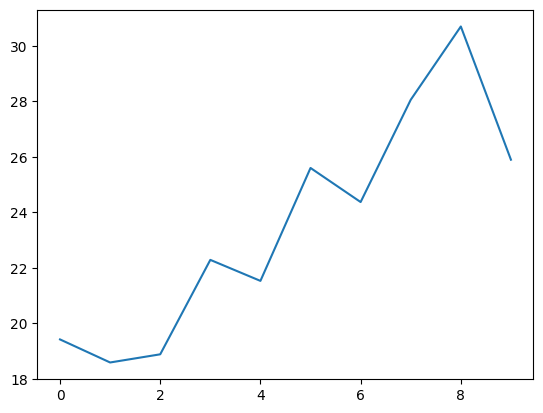

In [13]:
plt.plot(all_rewards)